In [ ]:
#!git clone https://github.com/opendp/smartnoise-sdk

In [1]:
pip install --editable smartnoise-sdk/synth

Obtaining file:///home/ec2-user/SageMaker/Utils_Update_11_26/smartnoise-sdk/synth
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 21.5 MB 23.1 MB/s eta 0:00:01
     |████████████████████████████████| 114 kB 73.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 43.9 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Running setup.py develop for smartnoise-synth
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install diffprivlib

     |████████████████████████████████| 76 kB 1.2 MB/s  eta 0:00:01
  Created wheel for diffprivlib: filename=diffprivlib-0.4.1-py3-none-any.whl size=153527 sha256=0354d4332d8ca26806b56d03db1b181e05aab9efc779013392523ee102b87700
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e2/62/db/d5e88bbc5847ac30bd88d15f401d26bd36d9038ebc2a21d2cd
Successfully built diffprivlib
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from diffprivlib.models import LogisticRegression as DPLR

from utils import convert_to_cat, one_hot_encode
from utils import get_synthesizer, get_quail_synthesizer, save_synthetic_data, plot_distributions
from utils import get_classification_summary, get_table_metrics, get_epsilon_plots
from utils import dp_model_classification_helper, get_dp_model_table_metrics

from kanon import convert_to_str, get_spans, partition_dataset, is_k_anonymous, build_anonymized_dataset, drop_grouped_rows

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Convert all columns to categorical

In [3]:
# Read in sample directly
adult_data = pd.read_csv('acs_income_data_sample.csv', index_col=False)
adult_data.head()

,Unnamed: 0,label,race,sex,hours_week,native_country,occupation,marital,education,workclass,age,relationship
0,806757,>50K,White alone,Female,40.0,27.0,CMS,Married,Bachelor's degree,Employee of a private for-profit company or bu...,41.0,Reference person
1,296415,<=50K,White alone,Female,25.0,8.0,EAT,Married,Regular high school diploma,Employee of a private for-profit company or bu...,19.0,Biological son or daughter
2,717607,<=50K,White alone,Female,20.0,216.0,OFF,Married,Bachelor's degree,Employee of a private for-profit company or bu...,41.0,Husband/wife
3,1574145,<=50K,White alone,Female,25.0,53.0,SAL,Divorced,Regular high school diploma,Employee of a private for-profit company or bu...,56.0,Reference person
4,765750,<=50K,Black or African American alone,Male,40.0,26.0,HLS,Never married,Regular high school diploma,Employee of a private for-profit company or bu...,25.0,Biological son or daughter


In [4]:
adult_data.columns

Index(['Unnamed: 0', 'label', 'race', 'sex', 'hours_week', 'native_country',
       'occupation', 'marital', 'education', 'workclass', 'age',
       'relationship'],
      dtype='object')

In [5]:
# Get the categorical data
cat_adult = convert_to_cat(adult_data, dataset="acs")
cat_adult

,label,race,sex,hours_week,occupation,marital,education,workclass,age,relationship
0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,1,0,1,1
2,0,0,0,1,2,0,0,0,0,2
3,0,0,0,1,3,1,1,0,2,0
4,0,1,1,0,4,2,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
29995,1,0,1,0,19,1,5,0,4,4
29996,1,0,0,0,17,0,0,0,0,0
29997,1,0,0,1,7,0,5,2,4,2
29998,0,0,1,0,17,2,4,4,3,11


In [6]:
# Get the one-hot encoded data
encoded_adult = one_hot_encode(cat_adult, dataset="acs")
encoded_adult

,label,sex,age_1,age_2,age_3,age_4,workclass_1,workclass_2,workclass_3,workclass_4,...,race_6,race_7,race_8,hours_week_1,hours_week_2,hours_week_3,marital_1,marital_2,marital_3,marital_4
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
29996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29997,1,0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
29998,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [7]:
# Split the categorical and one-hot encoded data into train and test
cat_train, cat_test = train_test_split(cat_adult, test_size=0.2, random_state=0)
encoded_train, encoded_test = train_test_split(encoded_adult, test_size=0.2, random_state=0)

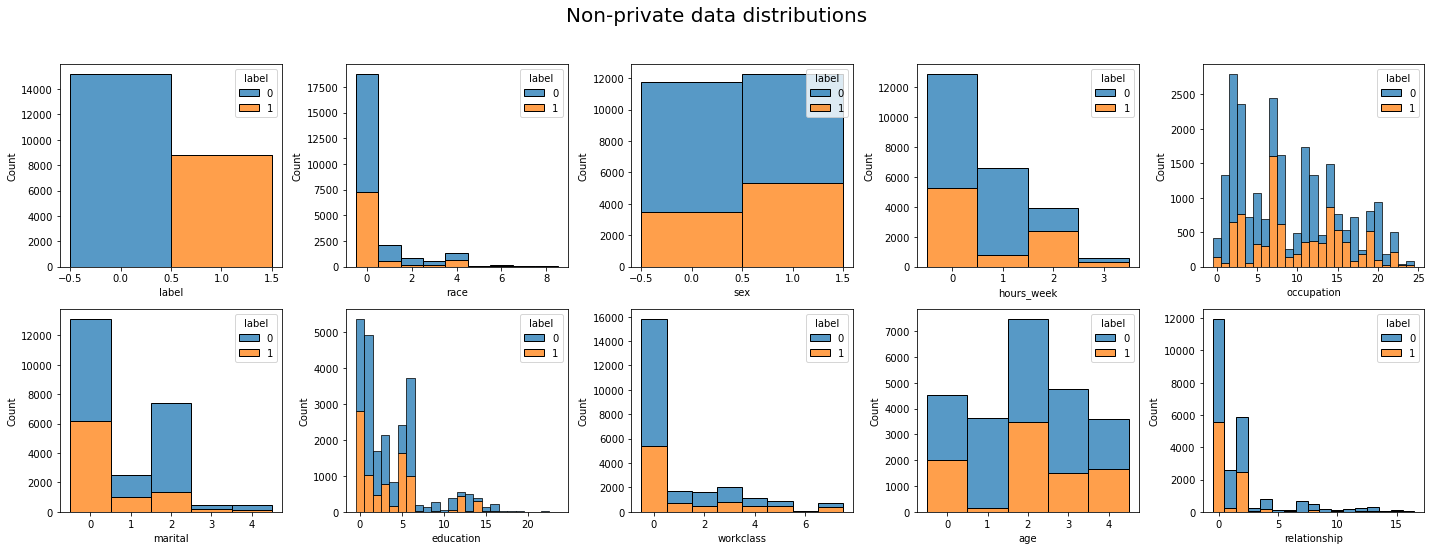

In [8]:
# Plot the non-private distributions
plot_distributions(cat_train, title="Non-private data distributions", dataset='acs')

# 2. Train binary classifier on non-private data

In [8]:
y_train_pred, y_test_pred = get_classification_summary(encoded_train, encoded_test, classifier="logistic", dataset="acs")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Female: 0.5902, Male: 0.7252

False positive rates:
Female: 0.1033, Male: 0.1831

Equalized odds distances:
y=1: 0.1351, y=0: 0.0798

Classification accuracies:
Female: 0.8032, Male: 0.7776

F1-score: 0.7028

Avg train pred: 0.3396, Avg test pred: 0.3373


In [10]:
y_train_pred, y_test_pred = get_classification_summary(encoded_train, encoded_test, classifier="forest", dataset="acs")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.5879, Male: 0.6873

False positive rates:
Female: 0.1323, Male: 0.2156

Equalized odds distances:
y=1: 0.0994, y=0: 0.0832

Classification accuracies:
Female: 0.7823, Male: 0.7427

F1-score: 0.6679

Avg train pred: 0.3629, Avg test pred: 0.3478


# 3. New MWEM synthesis

In [9]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [ ]:
# Generate 10 repetitions of synthetic data with MWEM
save_synthetic_data(epsilon_vals, cat_train, synthesizer="MWEM", n_reps=10, dataset="acs")

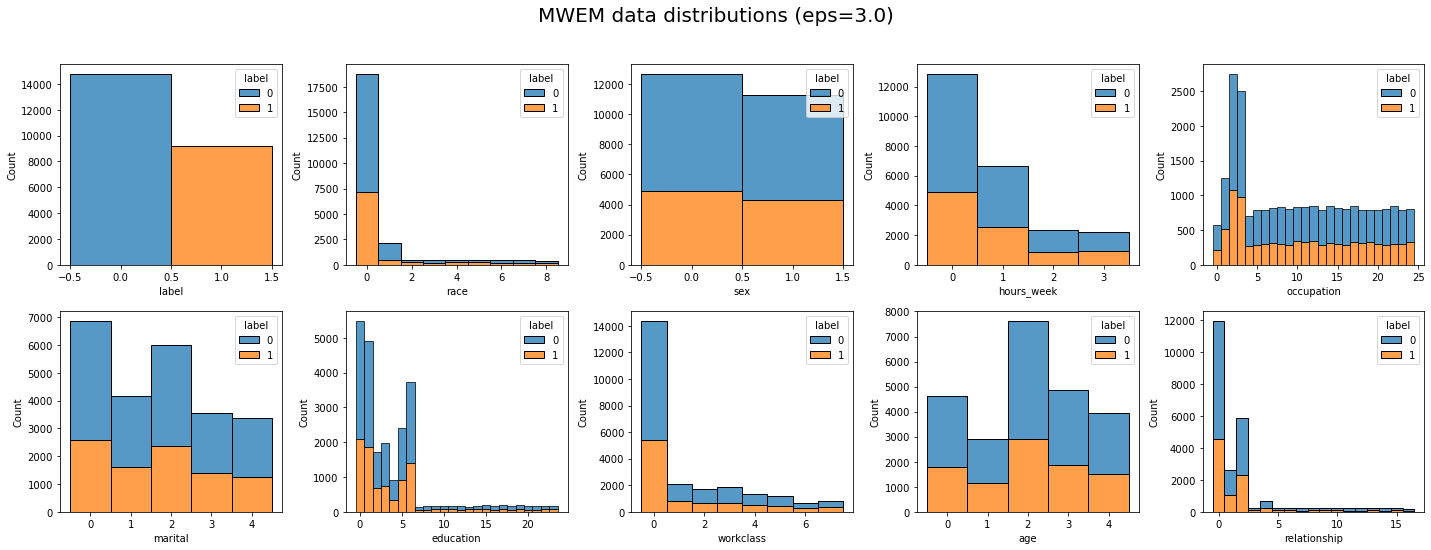

In [10]:
MWEM_eps3_rep0 = pd.read_csv("MWEM_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(MWEM_eps3_rep0, title="MWEM data distributions (eps=3.0)", dataset="acs")

In [11]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.010
FPR difference median: 0.002
F1-score median: 0.108


In [13]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("MWEM", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.002
FPR difference median: -0.003
F1-score median: 0.304


# 4. New DP-CTGAN synthesis

In [ ]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, cat_train, synthesizer="DPCTGAN", n_reps=5, dataset="acs")


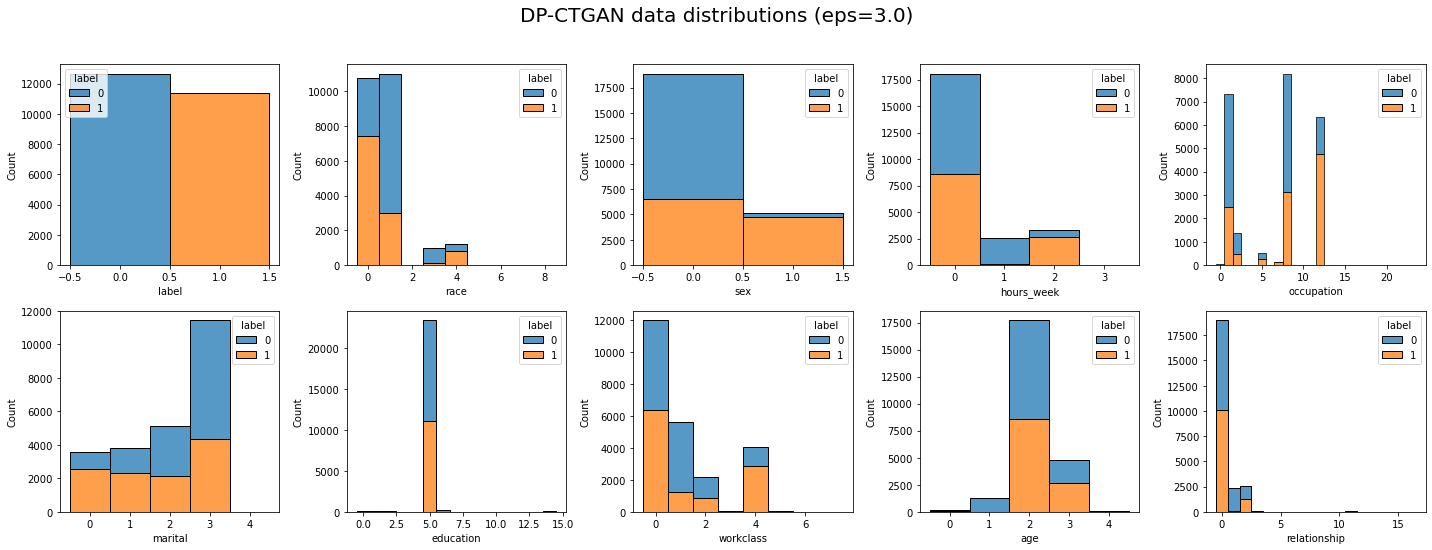

In [15]:
DPCTGAN_eps3_rep0 = pd.read_csv("DPCTGAN_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(DPCTGAN_eps3_rep0, title="DP-CTGAN data distributions (eps=3.0)", dataset="acs")

In [17]:
# Plot the table metrics for DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("DPCTGAN", epsilon_list=[3.0], nreps=5, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.574


In [18]:
# Plot the table metrics for DPCTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("DPCTGAN", epsilon_list=[3.0], nreps=5, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.003
FPR difference median: 0.010
F1-score median: 0.594


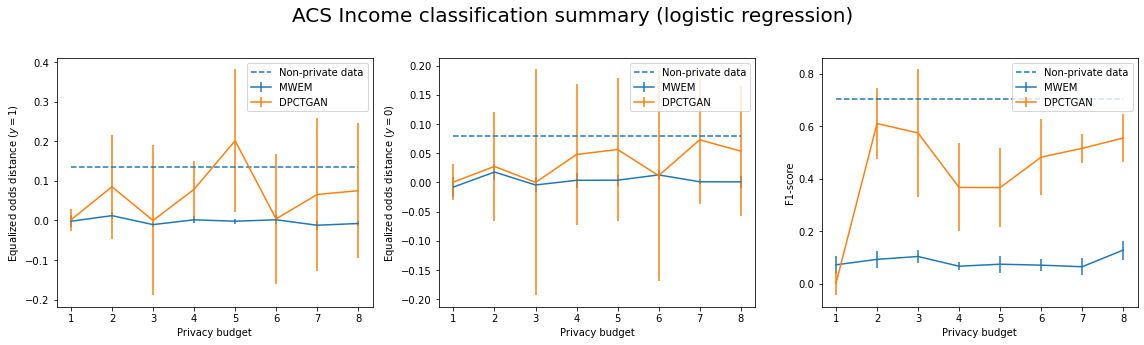

In [19]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=5, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs")

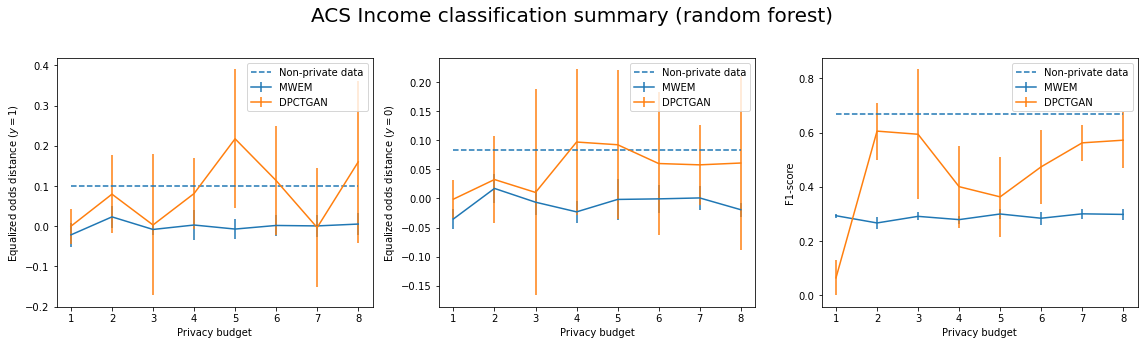

In [20]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=5, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs")

# 5. New PATE-CTGAN synthesis

In [ ]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

# Generate 10 repetitions of synthetic data with PATE-CTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="PATECTGAN", n_reps=10, dataset="acs")

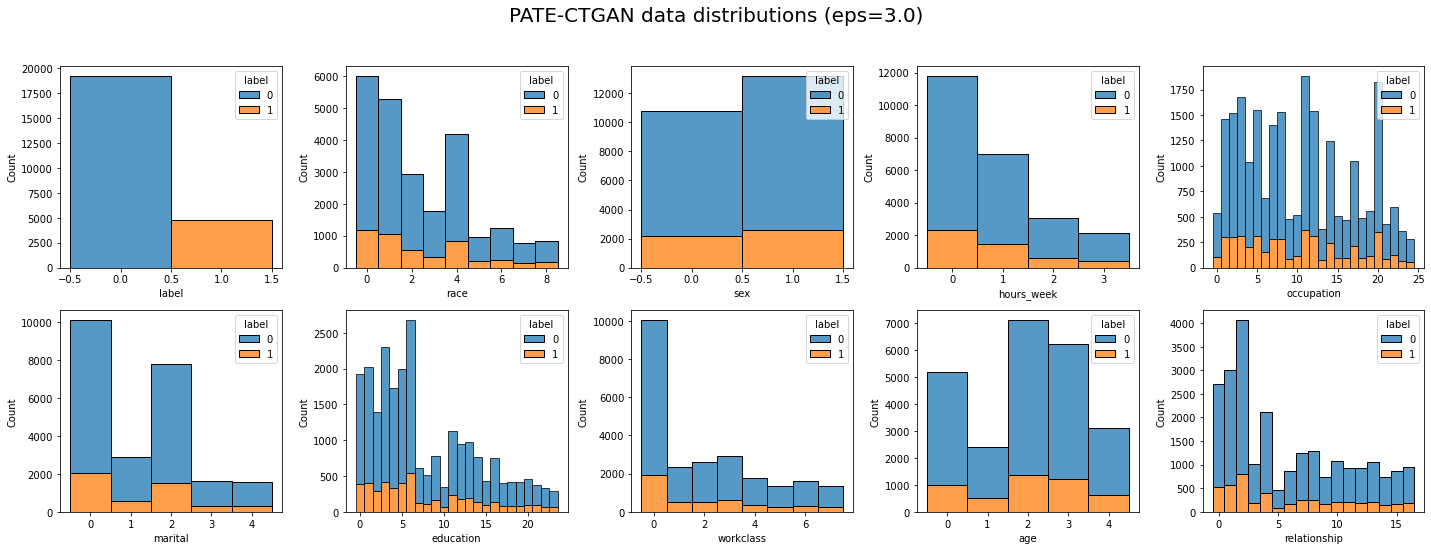

In [21]:
PATECTGAN_eps3_rep0 = pd.read_csv("PATECTGAN_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep0, title="PATE-CTGAN data distributions (eps=3.0)", dataset="acs")

In [22]:
# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.000


In [23]:
# Plot the table metrics for PATECTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.000
FPR difference median: -0.000
F1-score median: 0.010


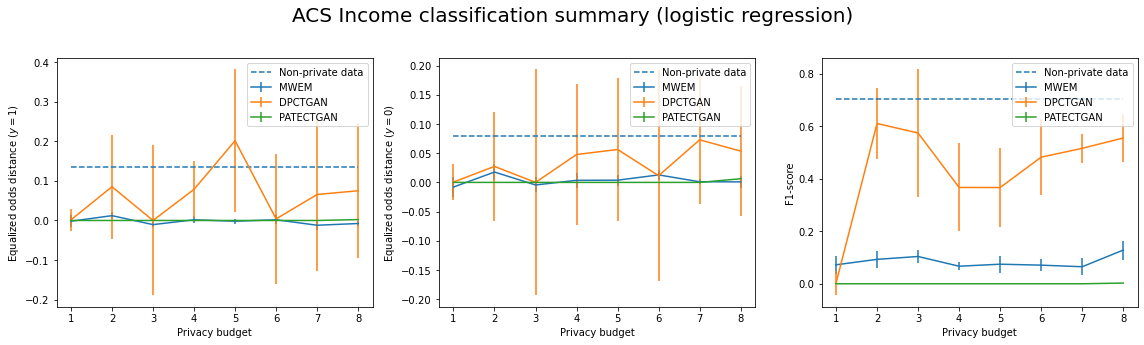

In [24]:
# Plot new MWEM, DP-CTGAN, and PATECTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN", "PATECTGAN"], epsilon_vals, nreps=5, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs")

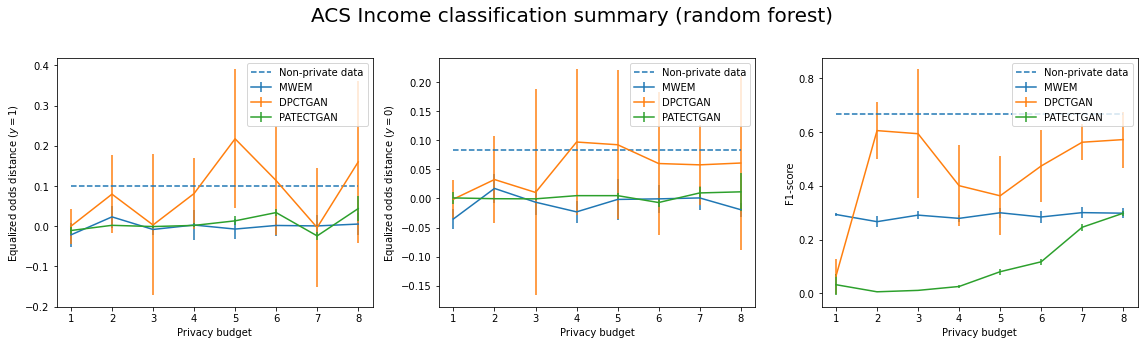

In [25]:
# Plot new MWEM and DP-CTGAN, and PATECTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN", "PATECTGAN"], epsilon_vals, nreps=5, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs")

# 6. New QUAIL-MWEM synthesis

In [26]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [27]:
# Generate 10 repetitions of synthetic data with QUAIL-MWEM
save_synthetic_data(epsilon_vals, cat_train, synthesizer="MWEM", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="acs")

Completed eps=1.0, rep=1.
Completed eps=1.0, rep=2.
Completed eps=1.0, rep=3.
Completed eps=1.0, rep=4.
Completed eps=1.0, rep=5.
Completed eps=1.0, rep=6.
Completed eps=1.0, rep=7.
Completed eps=1.0, rep=8.
Completed eps=1.0, rep=9.
Completed eps=1.0, rep=10.
Completed eps=2.0, rep=1.
Completed eps=2.0, rep=2.
Completed eps=2.0, rep=3.
Completed eps=2.0, rep=4.
Completed eps=2.0, rep=5.
Completed eps=2.0, rep=6.
Completed eps=2.0, rep=7.
Completed eps=2.0, rep=8.
Completed eps=2.0, rep=9.
Completed eps=2.0, rep=10.
Completed eps=3.0, rep=1.
Completed eps=3.0, rep=2.
Completed eps=3.0, rep=3.
Completed eps=3.0, rep=4.
Completed eps=3.0, rep=5.
Completed eps=3.0, rep=6.
Completed eps=3.0, rep=7.
Completed eps=3.0, rep=8.
Completed eps=3.0, rep=9.
Completed eps=3.0, rep=10.
Completed eps=4.0, rep=1.
Completed eps=4.0, rep=2.
Completed eps=4.0, rep=3.
Completed eps=4.0, rep=4.
Completed eps=4.0, rep=5.
Completed eps=4.0, rep=6.
Completed eps=4.0, rep=7.
Completed eps=4.0, rep=8.
Completed

In [28]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.244
FPR difference median: 0.123
F1-score median: 0.486


In [29]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.218
FPR difference median: 0.112
F1-score median: 0.485


# 7. New QUAIL-DPCTGAN synthesis

In [30]:
# Generate 10 repetitions of synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="DPCTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="acs")

Completed eps=1.0, rep=1.
Completed eps=1.0, rep=2.
Completed eps=1.0, rep=3.
Completed eps=1.0, rep=4.
Completed eps=1.0, rep=5.
Completed eps=1.0, rep=6.
Completed eps=1.0, rep=7.
Completed eps=1.0, rep=8.
Completed eps=1.0, rep=9.
Completed eps=1.0, rep=10.
Epoch 1, Loss G: 0.7056, Loss D: 1.3966
epsilon is 0.16118641571168127, alpha is 63.0
Completed eps=2.0, rep=1.
Epoch 1, Loss G: 0.7066, Loss D: 1.3949
epsilon is 0.16118641571168127, alpha is 63.0
Completed eps=2.0, rep=2.
Epoch 1, Loss G: 0.7062, Loss D: 1.3940
epsilon is 0.16118641571168127, alpha is 63.0
Completed eps=2.0, rep=3.
Epoch 1, Loss G: 0.7046, Loss D: 1.3900
epsilon is 0.16118641571168127, alpha is 63.0
Completed eps=2.0, rep=4.
Epoch 1, Loss G: 0.7065, Loss D: 1.3913
epsilon is 0.16118641571168127, alpha is 63.0
Completed eps=2.0, rep=5.
Epoch 1, Loss G: 0.7046, Loss D: 1.3924
epsilon is 0.16118641571168127, alpha is 63.0
Completed eps=2.0, rep=6.
Epoch 1, Loss G: 0.7062, Loss D: 1.3947
epsilon is 0.16118641571168

In [31]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.216
FPR difference median: 0.139
F1-score median: 0.437


In [32]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.049
FPR difference median: 0.024
F1-score median: 0.210


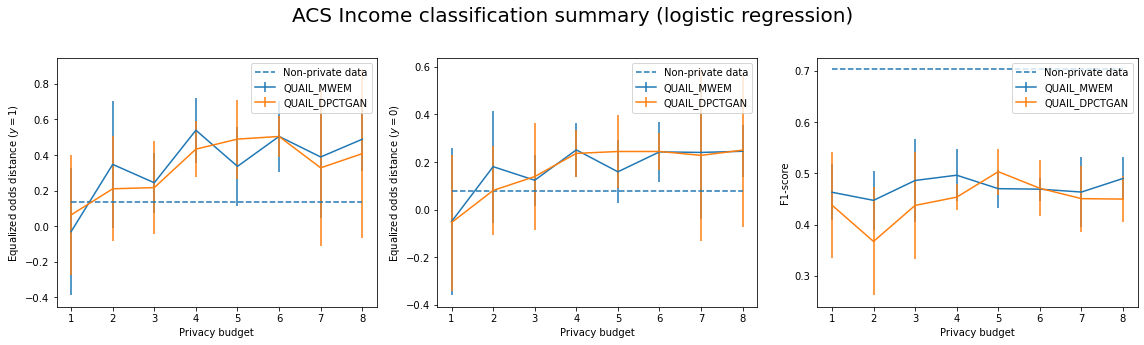

In [33]:
# Plot new MWEM and DPCTGAN results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs")


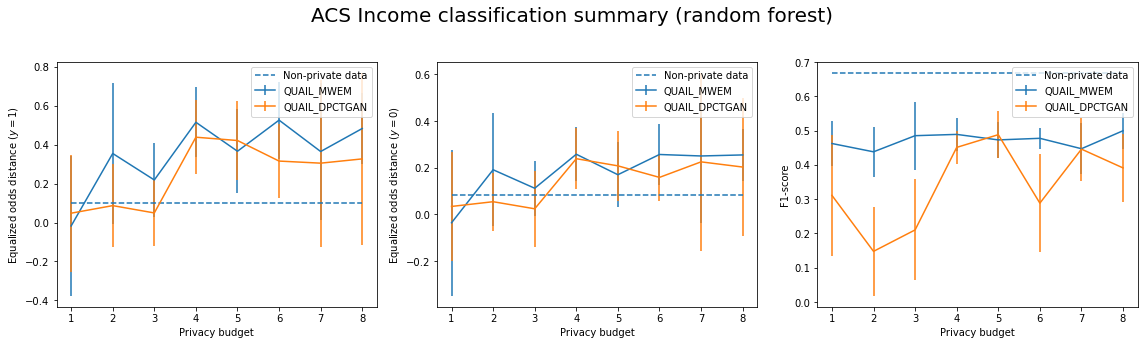

In [34]:
# Plot new MWEM and DPCTGAN results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs")


# 8. New QUAIL-PATECTGAN synthesis

In [35]:
# error: epsilon=1.0 too small?
epsilon_vals = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [36]:
# Generate 10 repetitions of synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="PATECTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="acs")


Completed eps=2.0, rep=1.
Completed eps=2.0, rep=2.
Completed eps=2.0, rep=3.
Completed eps=2.0, rep=4.
Completed eps=2.0, rep=5.
Completed eps=2.0, rep=6.
Completed eps=2.0, rep=7.
Completed eps=2.0, rep=8.
Completed eps=2.0, rep=9.
Completed eps=2.0, rep=10.
Completed eps=3.0, rep=1.
Completed eps=3.0, rep=2.
Completed eps=3.0, rep=3.
Completed eps=3.0, rep=4.
Completed eps=3.0, rep=5.
Completed eps=3.0, rep=6.
Completed eps=3.0, rep=7.
Completed eps=3.0, rep=8.
Completed eps=3.0, rep=9.
Completed eps=3.0, rep=10.
Completed eps=4.0, rep=1.
Completed eps=4.0, rep=2.
Completed eps=4.0, rep=3.
Completed eps=4.0, rep=4.
Completed eps=4.0, rep=5.
Completed eps=4.0, rep=6.
Completed eps=4.0, rep=7.
Completed eps=4.0, rep=8.
Completed eps=4.0, rep=9.
Completed eps=4.0, rep=10.
Completed eps=5.0, rep=1.
Completed eps=5.0, rep=2.
Completed eps=5.0, rep=3.
Completed eps=5.0, rep=4.
Completed eps=5.0, rep=5.
Completed eps=5.0, rep=6.
Completed eps=5.0, rep=7.
Completed eps=5.0, rep=8.
Completed

In [37]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.387
FPR difference median: 0.183
F1-score median: 0.408


In [38]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.020
FPR difference median: 0.013
F1-score median: 0.161


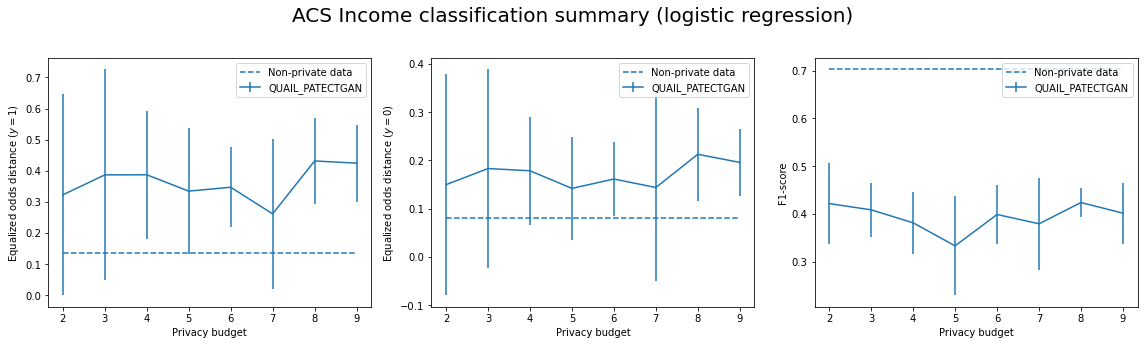

In [39]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs")


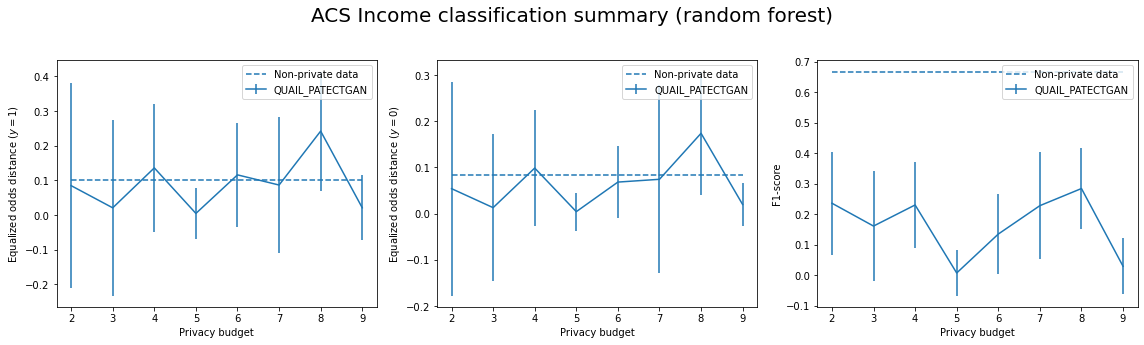

In [40]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs")


# 9. Comparison to DPLR

In [9]:
# Set range of epsilon values
epsilon_vals = [3.0]

# Calculate the median results
tpr_diff_median, fpr_diff_median, f1_score_median = get_dp_model_table_metrics(epsilon_vals, nreps=10, classifier="logistic", train_df=encoded_train, test_df=encoded_test, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.152
FPR difference median: 0.094
F1-score median: 0.665


# 10. Comparison to k-anonymity

In [10]:
# Convert categorical data into format required by k-anonymization algo
str_cat_train = convert_to_str(cat_train)

In [11]:
# Get the spans of the categorical variables
full_spans = get_spans(str_cat_train, str_cat_train.index)

In [12]:
# Specify the feature columns and label
feature_columns = ["age", "workclass", "education", "occupation",
                   "relationship", "race", "sex", "hours_week", "marital"]
sensitive_column = "label"

# Make partitions for k=3
finished_partitions = partition_dataset(str_cat_train, feature_columns, sensitive_column, full_spans, is_k_anonymous, k=3)

# Get the number of partitions created
len(finished_partitions)

5425

In [13]:
# Build anonymized data set
kanon_df = build_anonymized_dataset(str_cat_train, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...
Finished 501 partitions...
Finished 601 partitions...
Finished 701 partitions...
Finished 801 partitions...
Finished 901 partitions...
Finished 1001 partitions...
Finished 1101 partitions...
Finished 1201 partitions...
Finished 1301 partitions...
Finished 1401 partitions...
Finished 1501 partitions...
Finished 1601 partitions...
Finished 1701 partitions...
Finished 1801 partitions...
Finished 1901 partitions...
Finished 2001 partitions...
Finished 2101 partitions...
Finished 2201 partitions...
Finished 2301 partitions...
Finished 2401 partitions...
Finished 2501 partitions...
Finished 2601 partitions...
Finished 2701 partitions...
Finished 2801 partitions...
Finished 2901 partitions...
Finished 3001 partitions...
Finished 3101 partitions...
Finished 3201 partitions...
Finished 3301 partitions...
Finished 3401 partitions...
Finished 3501 partitions...
Fini

In [14]:
# Drop rows with grouped categories
kanon_df = drop_grouped_rows(kanon_df, dataset="acs")
kanon_df

,age,workclass,education,occupation,relationship,race,sex,hours_week,marital,label
5,4,5,6,3,0,3,1,2,0,0
6,4,5,6,3,0,3,1,2,0,1
10,2,7,5,2,1,3,1,1,2,0
11,2,7,5,2,1,3,1,1,2,1
12,2,0,9,3,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...
8490,2,0,1,5,0,0,1,0,0,1
8491,2,0,1,3,0,0,1,0,0,0
8492,2,0,1,3,0,0,1,0,0,1
8497,3,0,0,2,0,0,0,0,2,0


In [15]:
# One-hot encode the k-anonymized data
encoded_kanon = one_hot_encode(kanon_df, dataset="acs")

# Get classification summary for k-anonymized training data
y_train_pred, y_test_pred = get_classification_summary(encoded_kanon, encoded_test, classifier="logistic", dataset="acs")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Female: 0.3607, Male: 0.6664

False positive rates:
Female: 0.0622, Male: 0.2105

Equalized odds distances:
y=1: 0.3057, y=0: 0.1484

Classification accuracies:
Female: 0.7618, Male: 0.7367

F1-score: 0.6163

Avg train pred: 0.2988, Avg test pred: 0.2852


# 11. Pre-processing (undersampling before synth)

In [16]:
def multi_undersample(cat_df, protected_att, target):
    
    # Count the number of rows for each group and target label
    group0_counts = [len(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)]), len(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)])]
    group1_counts = [len(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)]), len(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)])]
    all_counts = group0_counts + group1_counts
    
    # Identify the minority count (w.r.t group and label)
    min_count_id = np.argmin(all_counts)
    min_count = all_counts[min_count_id]
    
    # Randomly drop rows from the same group and opposite label
    if min_count_id == 0:
        count_diff = all_counts[1] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(all_counts[2]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(all_counts[3]-min_count).index)
    elif min_count_id == 1:
        count_diff = all_counts[0] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(all_counts[2]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(all_counts[3]-min_count).index)
    elif min_count_id == 2:
        count_diff = all_counts[3] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(all_counts[0]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(all_counts[1]-min_count).index)
    else:
        count_diff = all_counts[2] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(all_counts[0]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(all_counts[1]-min_count).index)    
    
    return cat_df

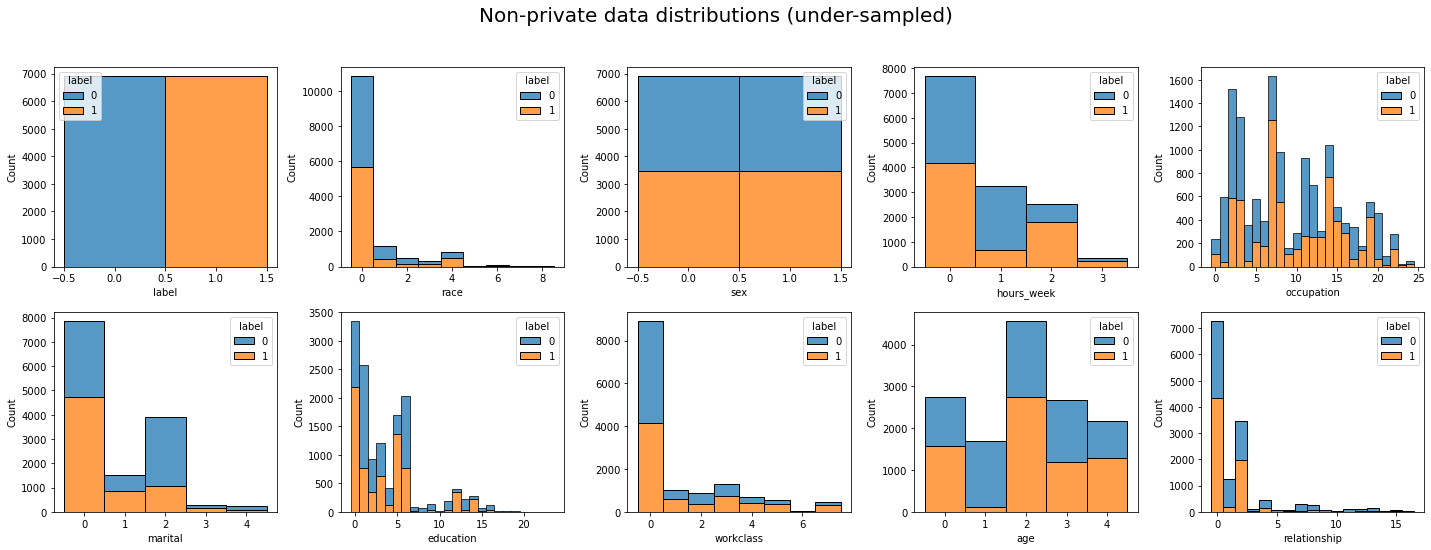

In [17]:
# Balance the groups and labels
multi_balanced = multi_undersample(cat_train, protected_att="sex", target="label")
plot_distributions(multi_balanced, title="Non-private data distributions (under-sampled)", dataset="acs")

In [18]:
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [20]:
# Generate 10 repetitions of preprocessed synthetic data with QUAIL-MWEM
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="MWEM", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="acs", results_dir="preprocessed/")

Completed eps=1.0, rep=1.
Completed eps=1.0, rep=2.
Completed eps=1.0, rep=3.
Completed eps=1.0, rep=4.
Completed eps=1.0, rep=5.
Completed eps=1.0, rep=6.
Completed eps=1.0, rep=7.
Completed eps=1.0, rep=8.
Completed eps=1.0, rep=9.
Completed eps=1.0, rep=10.
Completed eps=2.0, rep=1.
Completed eps=2.0, rep=2.
Completed eps=2.0, rep=3.
Completed eps=2.0, rep=4.
Completed eps=2.0, rep=5.
Completed eps=2.0, rep=6.
Completed eps=2.0, rep=7.
Completed eps=2.0, rep=8.
Completed eps=2.0, rep=9.
Completed eps=2.0, rep=10.
Completed eps=3.0, rep=1.
Completed eps=3.0, rep=2.
Completed eps=3.0, rep=3.
Completed eps=3.0, rep=4.
Completed eps=3.0, rep=5.
Completed eps=3.0, rep=6.
Completed eps=3.0, rep=7.
Completed eps=3.0, rep=8.
Completed eps=3.0, rep=9.
Completed eps=3.0, rep=10.
Completed eps=4.0, rep=1.
Completed eps=4.0, rep=2.
Completed eps=4.0, rep=3.
Completed eps=4.0, rep=4.
Completed eps=4.0, rep=5.
Completed eps=4.0, rep=6.
Completed eps=4.0, rep=7.
Completed eps=4.0, rep=8.
Completed

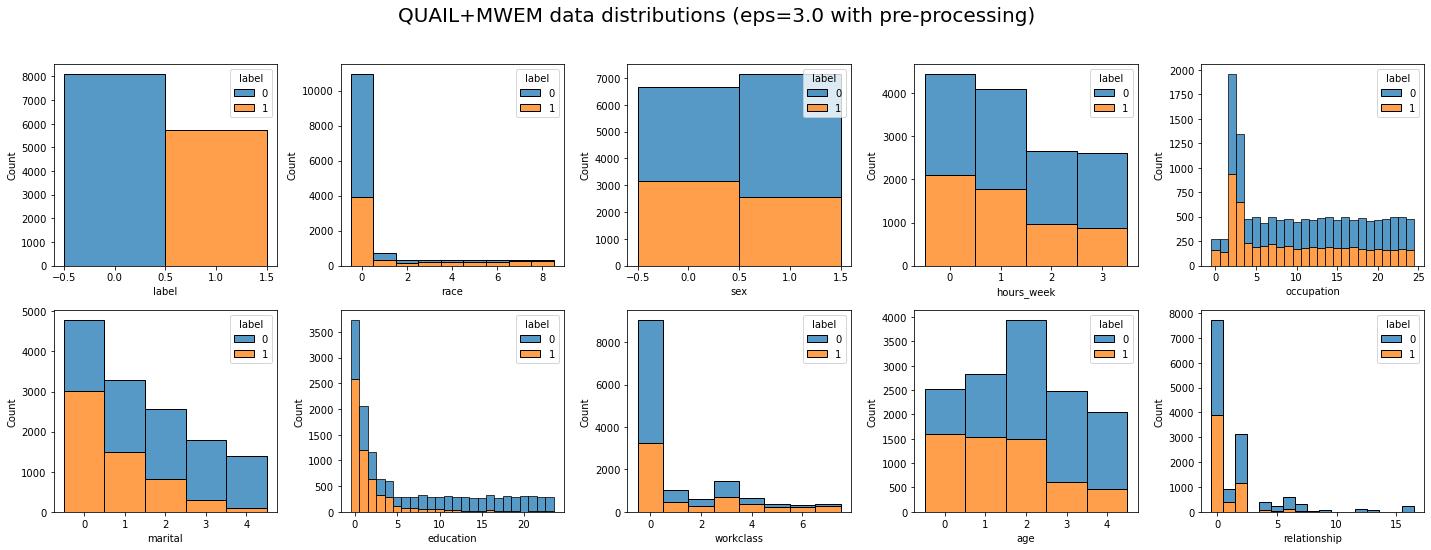

In [21]:
# Plot distributions of pre-processed synthetic data
QUAIL_MWEM_eps3_rep0 = pd.read_csv("preprocessed/QUAIL_MWEM_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(QUAIL_MWEM_eps3_rep0, title="QUAIL+MWEM data distributions (eps=3.0 with pre-processing)", dataset="acs")


In [ ]:
# Generate 10 repetitions of preprocessed synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="DPCTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="acs", results_dir="preprocessed/")


Completed eps=1.0, rep=1.
Completed eps=1.0, rep=2.
Completed eps=1.0, rep=3.
Completed eps=1.0, rep=4.
Completed eps=1.0, rep=5.
Completed eps=1.0, rep=6.
Completed eps=1.0, rep=7.
Completed eps=1.0, rep=8.
Completed eps=1.0, rep=9.
Completed eps=1.0, rep=10.
Epoch 1, Loss G: 0.7090, Loss D: 1.3914
epsilon is 0.14784010236604628, alpha is 63.0
Completed eps=2.0, rep=1.
Epoch 1, Loss G: 0.7117, Loss D: 1.3939
epsilon is 0.14784010236604628, alpha is 63.0
Completed eps=2.0, rep=2.
Epoch 1, Loss G: 0.7071, Loss D: 1.3943
epsilon is 0.14784010236604628, alpha is 63.0
Completed eps=2.0, rep=3.
Epoch 1, Loss G: 0.7113, Loss D: 1.3899
epsilon is 0.14784010236604628, alpha is 63.0
Completed eps=2.0, rep=4.
Epoch 1, Loss G: 0.7093, Loss D: 1.3932
epsilon is 0.14784010236604628, alpha is 63.0
Completed eps=2.0, rep=5.
Epoch 1, Loss G: 0.7119, Loss D: 1.3920
epsilon is 0.14784010236604628, alpha is 63.0
Completed eps=2.0, rep=6.
Epoch 1, Loss G: 0.7093, Loss D: 1.3923
epsilon is 0.14784010236604

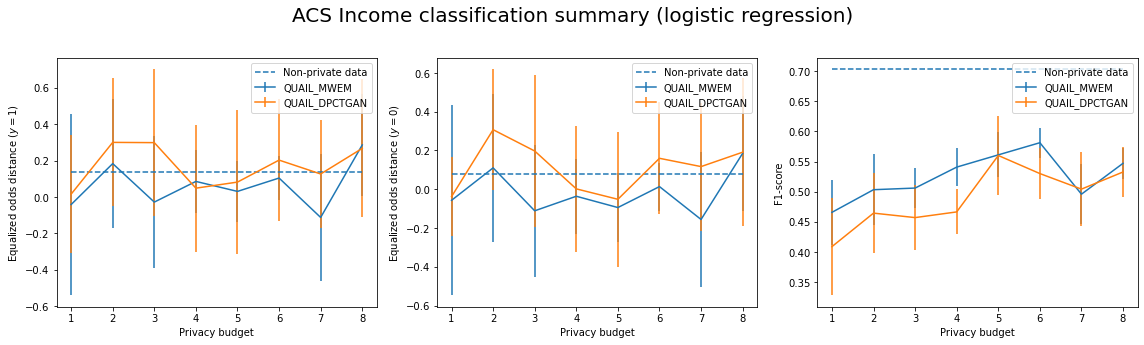

In [25]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs", results_dir="preprocessed/")


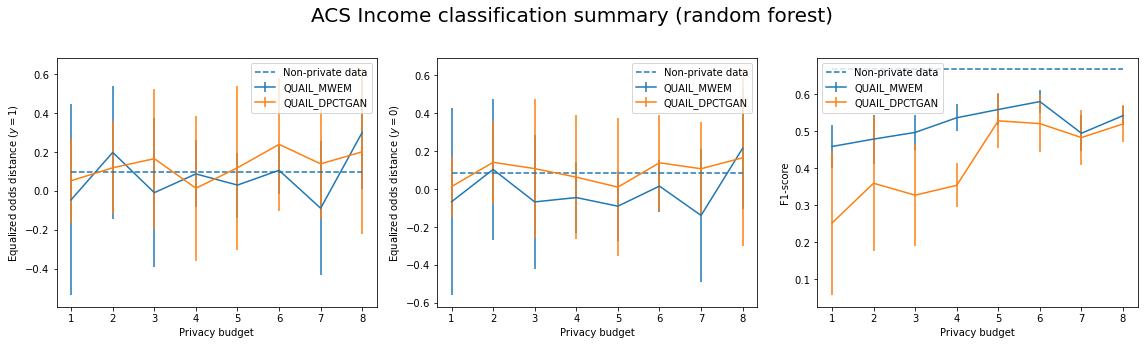

In [26]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs", results_dir="preprocessed/")


In [27]:
# Generate 10 repetitions of synthetic data with MWEM
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="MWEM", n_reps=10, dataset="acs", results_dir="preprocessed/")


Completed eps=1.0, rep=1.
Completed eps=1.0, rep=2.
Completed eps=1.0, rep=3.
Completed eps=1.0, rep=4.
Completed eps=1.0, rep=5.
Completed eps=1.0, rep=6.
Completed eps=1.0, rep=7.
Completed eps=1.0, rep=8.
Completed eps=1.0, rep=9.
Completed eps=1.0, rep=10.
Completed eps=2.0, rep=1.
Completed eps=2.0, rep=2.
Completed eps=2.0, rep=3.
Completed eps=2.0, rep=4.
Completed eps=2.0, rep=5.
Completed eps=2.0, rep=6.
Completed eps=2.0, rep=7.
Completed eps=2.0, rep=8.
Completed eps=2.0, rep=9.
Completed eps=2.0, rep=10.
Completed eps=3.0, rep=1.
Completed eps=3.0, rep=2.
Completed eps=3.0, rep=3.
Completed eps=3.0, rep=4.
Completed eps=3.0, rep=5.
Completed eps=3.0, rep=6.
Completed eps=3.0, rep=7.
Completed eps=3.0, rep=8.
Completed eps=3.0, rep=9.
Completed eps=3.0, rep=10.
Completed eps=4.0, rep=1.
Completed eps=4.0, rep=2.
Completed eps=4.0, rep=3.
Completed eps=4.0, rep=4.
Completed eps=4.0, rep=5.
Completed eps=4.0, rep=6.
Completed eps=4.0, rep=7.
Completed eps=4.0, rep=8.
Completed

In [28]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="DPCTGAN", n_reps=10, dataset="acs", results_dir="preprocessed/")


Epoch 1, Loss G: 0.6484, Loss D: 1.3906
epsilon is 0.14784010236604628, alpha is 63.0
Epoch 2, Loss G: 0.6456, Loss D: 1.3896
epsilon is 0.2477127855007385, alpha is 63.0
Epoch 3, Loss G: 0.6375, Loss D: 1.4010
epsilon is 0.34429451075593576, alpha is 56.0
Epoch 4, Loss G: 0.6438, Loss D: 1.3952
epsilon is 0.42337178728722885, alpha is 47.0
Epoch 5, Loss G: 0.6513, Loss D: 1.3893
epsilon is 0.4907616453760461, alpha is 41.0
Epoch 6, Loss G: 0.6550, Loss D: 1.3866
epsilon is 0.5506417410002586, alpha is 37.0
Epoch 7, Loss G: 0.6554, Loss D: 1.3912
epsilon is 0.6051400216722752, alpha is 35.0
Epoch 8, Loss G: 0.6549, Loss D: 1.3890
epsilon is 0.6554770184050852, alpha is 32.0
Epoch 9, Loss G: 0.6553, Loss D: 1.3873
epsilon is 0.7026571408839662, alpha is 30.0
Epoch 10, Loss G: 0.6597, Loss D: 1.3871
epsilon is 0.747057951389356, alpha is 29.0
Epoch 11, Loss G: 0.6577, Loss D: 1.3876
epsilon is 0.7894091715735249, alpha is 28.0
Epoch 12, Loss G: 0.6578, Loss D: 1.3854
epsilon is 0.8296993

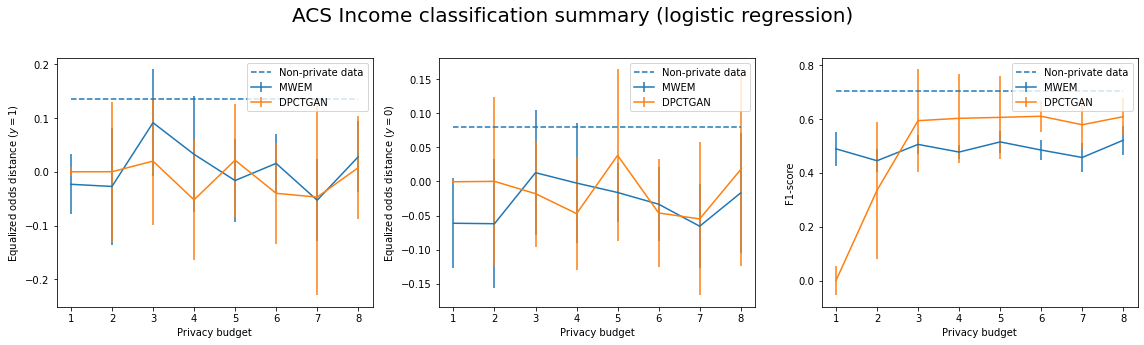

In [29]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs", results_dir="preprocessed/")


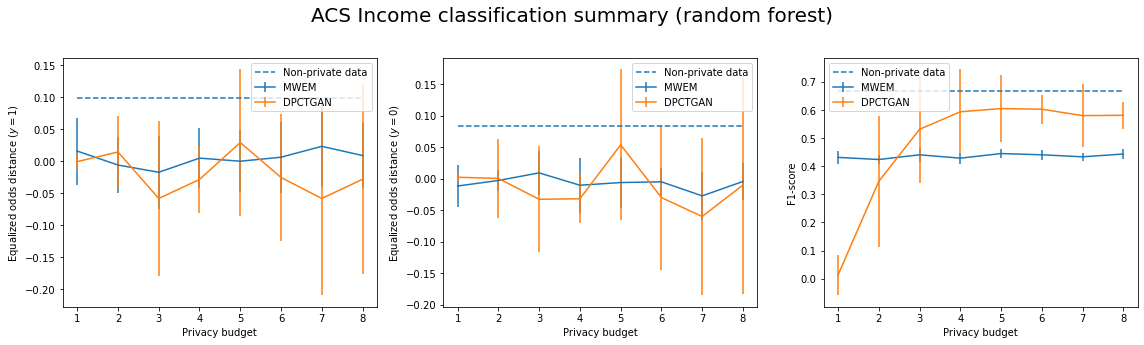

In [30]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs", results_dir="preprocessed/")
